<a href="https://colab.research.google.com/github/naenumtou/statisticalModel/blob/main/gammaFitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import gamma
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

%config InlineBackend.figure_format = 'retina'

In [2]:
# Import dataset
df = pd.read_csv('https://raw.githubusercontent.com/naenumtou/statisticalModel/main/datasets/PDRiskGrade.csv')
df = df.set_index(['Segment', 'Aging', 'N']) #Set index to avoid un-used columns
df

1         2  ...        59        60
Segment Aging N                            ...                    
CU      0     1425717  0.000038  0.000100  ...  0.070381  0.070581
        1     178034   0.000219  0.005308  ...  0.264745  0.265104
        2     73212    0.015530  0.084890  ...  0.455843  0.456415
        3     14363    0.431247  0.514865  ...  0.809061  0.809540
HU      0     4232680  0.000043  0.000116  ...  0.047413  0.047596
        1     423105   0.000340  0.003654  ...  0.223064  0.223404
        2     164827   0.011291  0.070431  ...  0.434217  0.434904
        3     30127    0.398181  0.479437  ...  0.792708  0.792938

[8 rows x 60 columns]

In [3]:
# Defind Gamma Cumulative Densities function
def gammaFitting(x, alphaEst, betaEst, lambdaEst):
  return gamma.cdf(x, alphaEst, 0, betaEst) * lambdaEst

# Initial guess for estimating parameters
initialGuess = [1, 1, 1] #Three paramaters to estimate

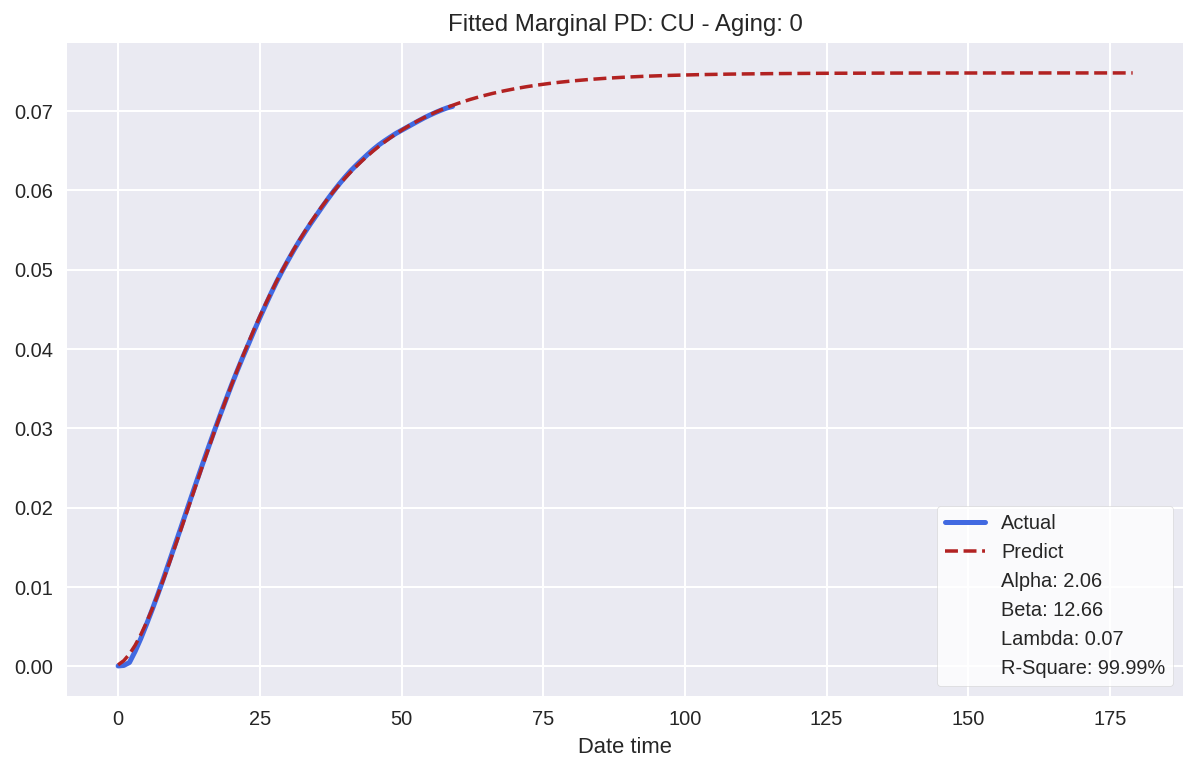

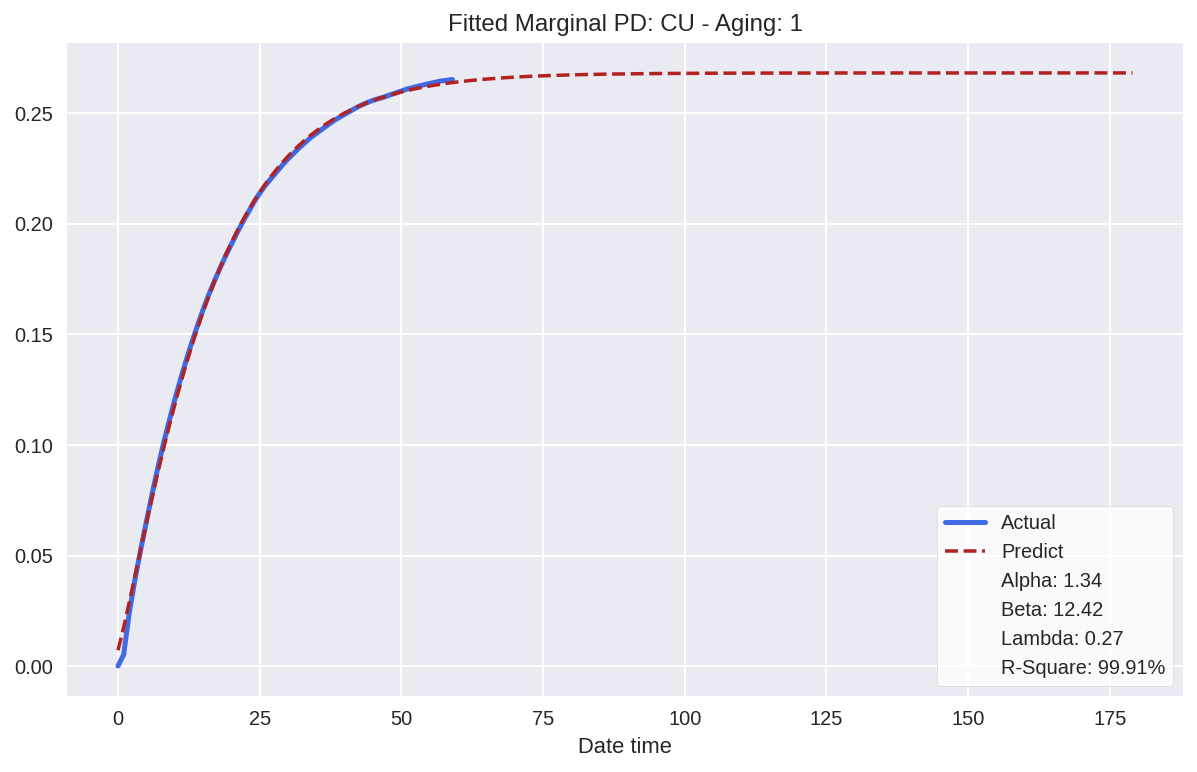

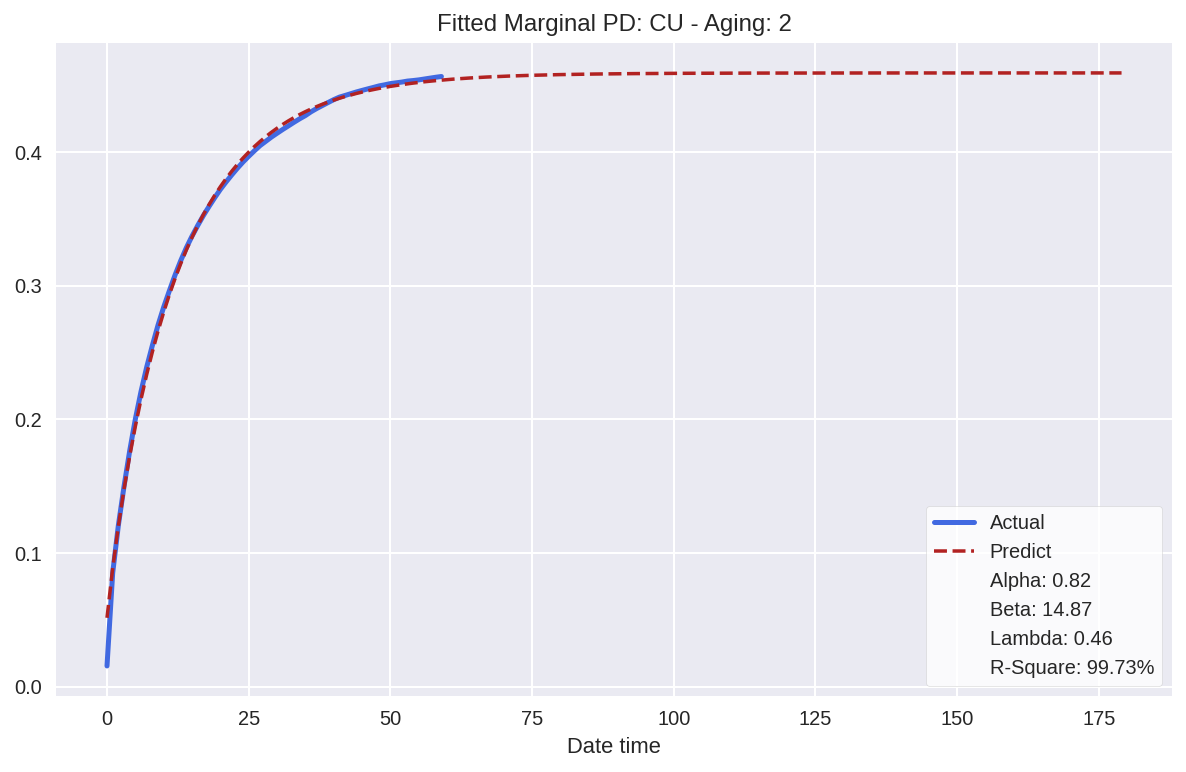

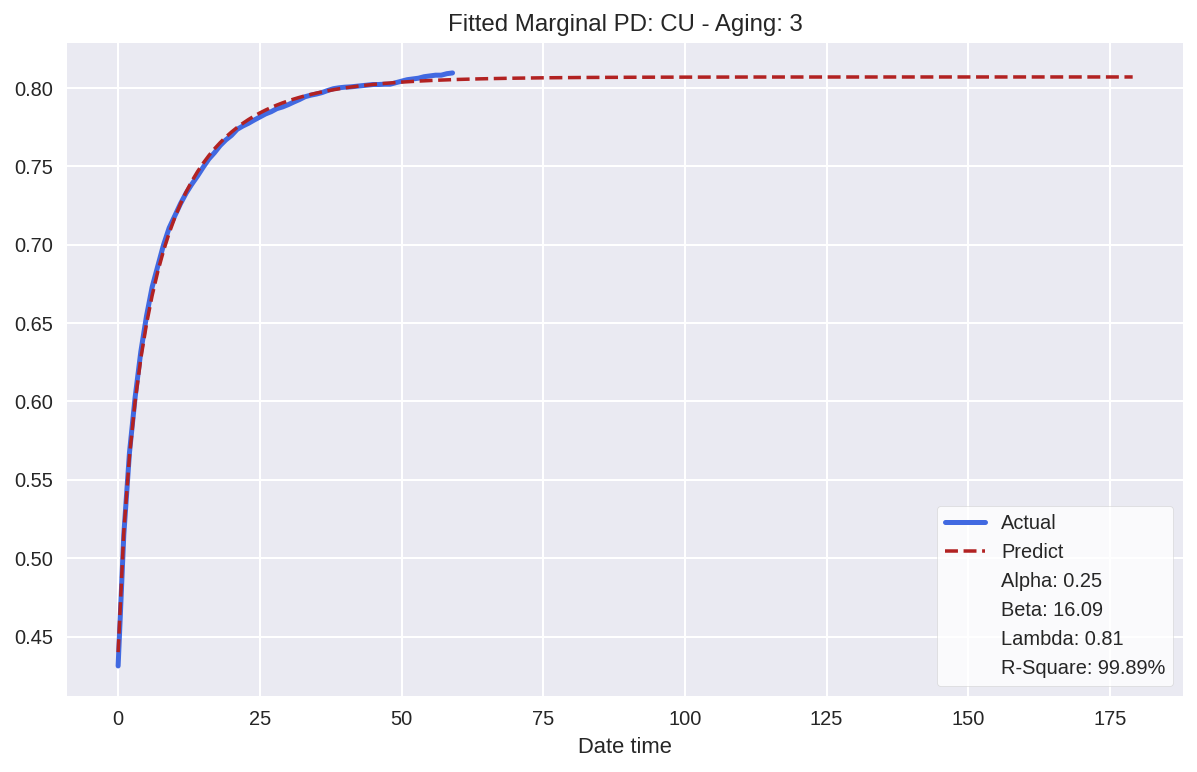

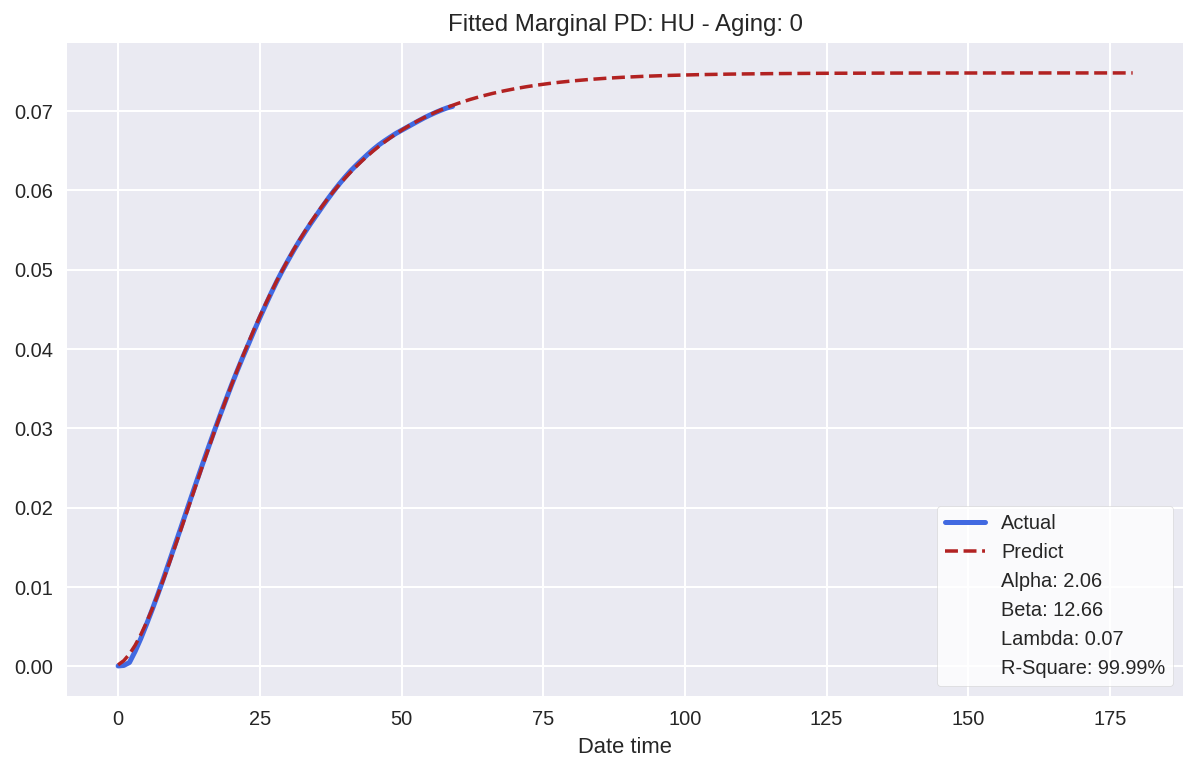

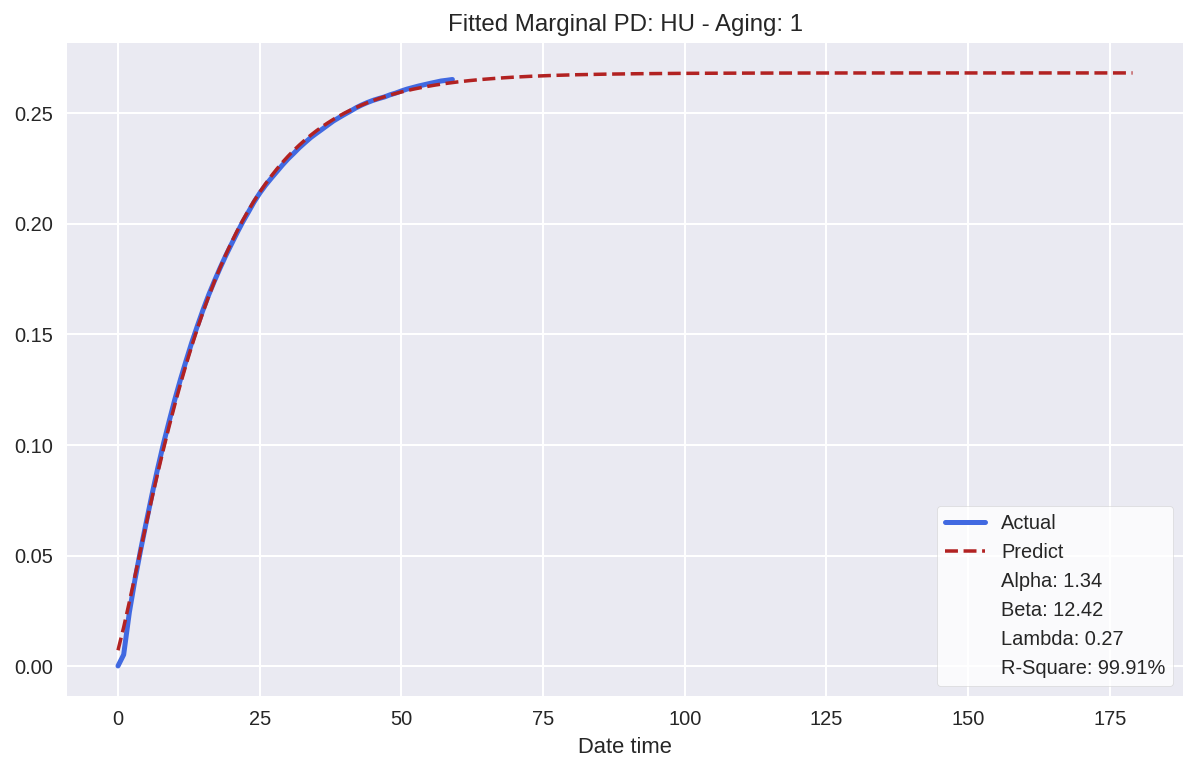

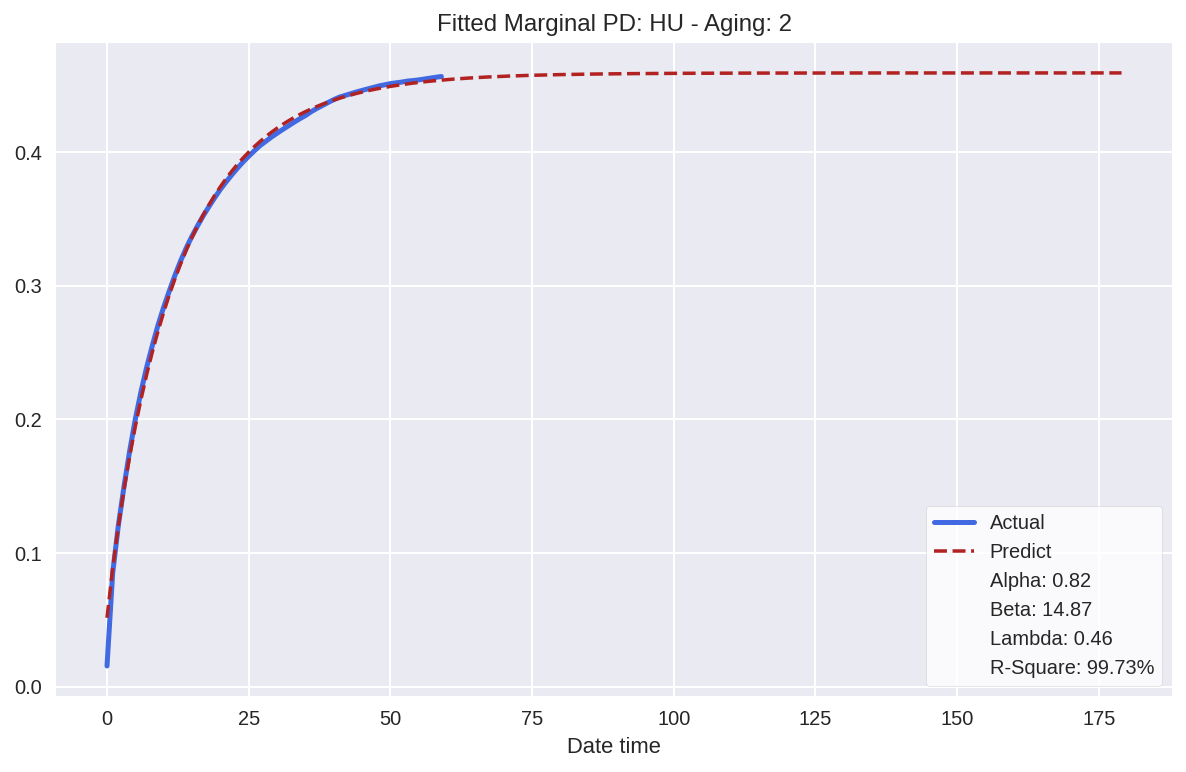

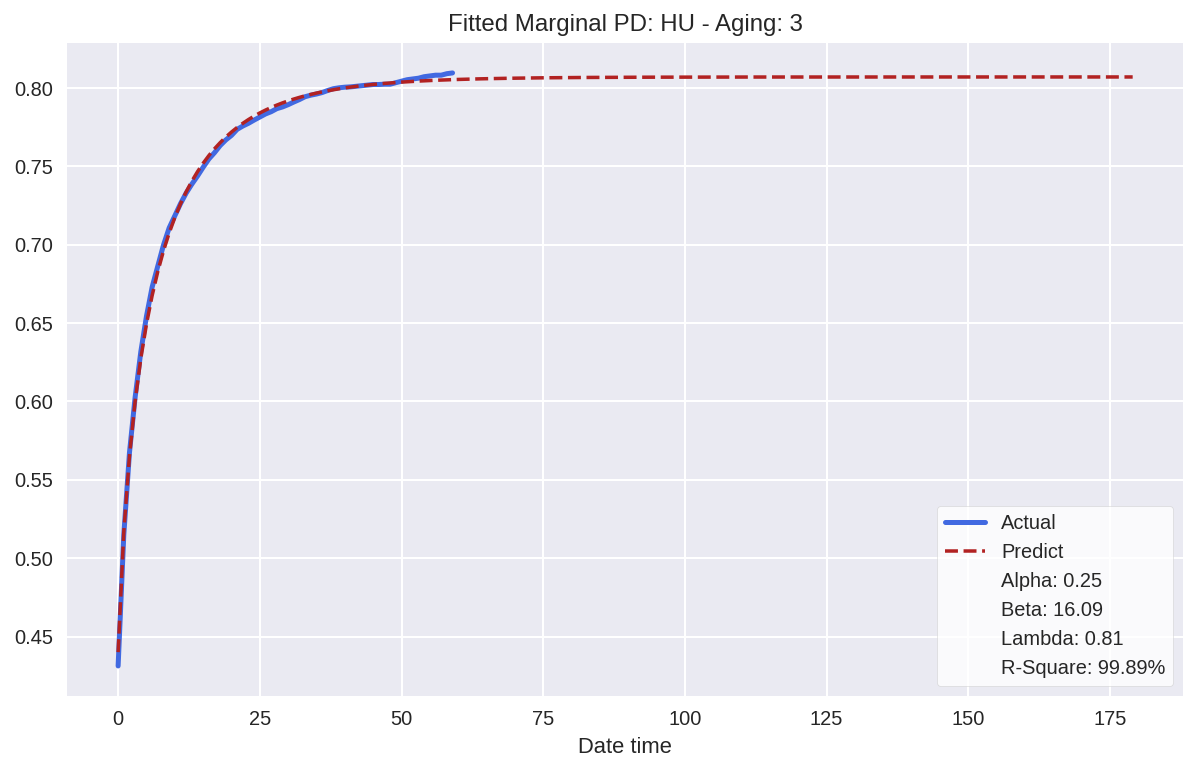

In [4]:
# Iteration for gamma fitting
fittedPD = None

for segment in df.index.get_level_values(0).unique(): #Get unique values from index
  for aging, i in zip(df.index.get_level_values(1).unique(), range(df.shape[0])):

    # # Calculate gamma fitting by segment and risk grade
    odr = df.values[i]
    year = np.arange(1, odr.shape[0] + 1)

    # Curves fitting
    popt, _ = curve_fit(gammaFitting, year, odr, initialGuess, maxfev = 100000) #Increase iteration number

    # Estimating from fitted parameters
    n = 10 #Define estimation year (plus 10 Years)
    yearEst = np.arange(1, odr.shape[0] + n * 12 + 1) #Create lifetime PD
    fittedODR = [gammaFitting(x, *popt) for x in yearEst] #Fitted maginal PD
    score = r2_score(odr, fittedODR[0:odr.shape[0]]) #Using only avaliable data

    # Fitted result
    if fittedPD is None:
      fittedPD = np.array(fittedODR).reshape(1, -1).copy()
    else:
      fittedPD = np.vstack((fittedPD, np.array(fittedODR).reshape(1, -1)))

    # Plot
    plt.figure(figsize = (10, 6))
    with plt.style.context('seaborn'):
      plt.title(f'Fitted Marginal PD: {segment} - Aging: {aging}')
      plt.xlabel('Date time')
      plt.plot(odr, c = 'royalblue', linewidth = 2.5, label = 'Actual')
      plt.plot(fittedODR, c = 'firebrick', linestyle = '--', label = 'Predict')

      # Add text to legend
      plt.plot([], [], ' ', label = f'Alpha: {popt[0]:.2f}')
      plt.plot([], [], ' ', label = f'Beta: {popt[1]:.2f}')
      plt.plot([], [], ' ', label = f'Lambda: {popt[2]:.2f}')
      plt.plot([], [], ' ', label = f'R-Square: {score * 100:.2f}%')
      plt.legend(frameon = True, facecolor = 'white')
      plt.savefig(f'plot{segment}_{aging}.png')
      plt.show()

In [5]:
# Fitted table
fittedTable = pd.DataFrame(fittedPD)
fittedTable.columns = [x for x in range(1, fittedTable.shape[1] + 1)] #Change columns name and type
fittedTable.index = df.index #Set index from initial table
fittedTable

1         2    ...       179       180
Segment Aging N                            ...                    
CU      0     1425717  0.000177  0.000702  ...  0.074797  0.074797
        1     178034   0.007298  0.017668  ...  0.268060  0.268060
        2     73212    0.051531  0.088485  ...  0.459086  0.459087
        3     14363    0.440041  0.516764  ...  0.806967  0.806967
HU      0     4232680  0.000177  0.000702  ...  0.074797  0.074797
        1     423105   0.007298  0.017668  ...  0.268060  0.268060
        2     164827   0.051531  0.088485  ...  0.459086  0.459087
        3     30127    0.440041  0.516764  ...  0.806967  0.806967

[8 rows x 180 columns]

In [6]:
# Table combination with actual ODR
# Fitted table
comparedTable = pd.melt(fittedTable.reset_index(level = ['Segment', 'Aging']),
                        id_vars = ['Segment', 'Aging'],
                        var_name = 'times',
                        value_name = 'cumPD')
comparedTable = comparedTable.sort_values(by = ['Segment', 'Aging', 'times'])
comparedTable['PDTypes'] = 'fittedPD' #Key categorical

# Actual table
dfActual = pd.melt(df.reset_index(level = ['Segment', 'Aging']),
                   id_vars = ['Segment', 'Aging'],
                   var_name = 'times',
                   value_name = 'cumPD')
dfActual['times'] = dfActual['times'].astype(np.int8) #Change data type
dfActual = dfActual.sort_values(by = ['Segment', 'Aging', 'times'])
dfActual['PDTypes'] = 'actualPD' #Key categorical

# Concat table
comparedTable = pd.concat([comparedTable, dfActual],
                          axis = 0,
                          ignore_index = True)
comparedTable = comparedTable.sort_values(by = ['Segment', 'Aging', 'PDTypes', 'times']) #For better plot

# Marginal PD
comparedTable['marPD'] = comparedTable.groupby(['Segment', 'Aging', 'PDTypes'])['cumPD'].diff().fillna(comparedTable['cumPD'])
comparedTable.head(5)

,Segment,Aging,times,cumPD,PDTypes,marPD
1440,CU,0,1,0.000038,actualPD,0.000038
1441,CU,0,2,0.000100,actualPD,0.000062
1442,CU,0,3,0.000475,actualPD,0.000375
1443,CU,0,4,0.001878,actualPD,0.001404
1444,CU,0,5,0.003492,actualPD,0.001614


In [7]:
# Define plot function
def plotCompare(data, PDType):
  for segment in data['Segment'].unique():

    #Data selection
    selectData = data[data['Segment'] == segment]

    # Create name
    if PDType == 'cumPD':
      name = 'Cumulative PD'
    else:
      name = 'Marginal PD'

    #Plot creation
    plt.figure(figsize = (10, 6))
    with plt.style.context('seaborn'):
      ax = sns.lineplot(x = 'times',
                        y = PDType,
                        data = selectData,
                        hue = 'Aging',
                        style = 'PDTypes',
                        legend = 'full',
                        palette = 'viridis',
                        ci = None)
      ax.set_title(f'{name}: {segment}')
      ax.set(xlabel = 'Time', ylabel = 'PD')
      plt.savefig(f'{name}_{segment}.png')
  return plt.show()

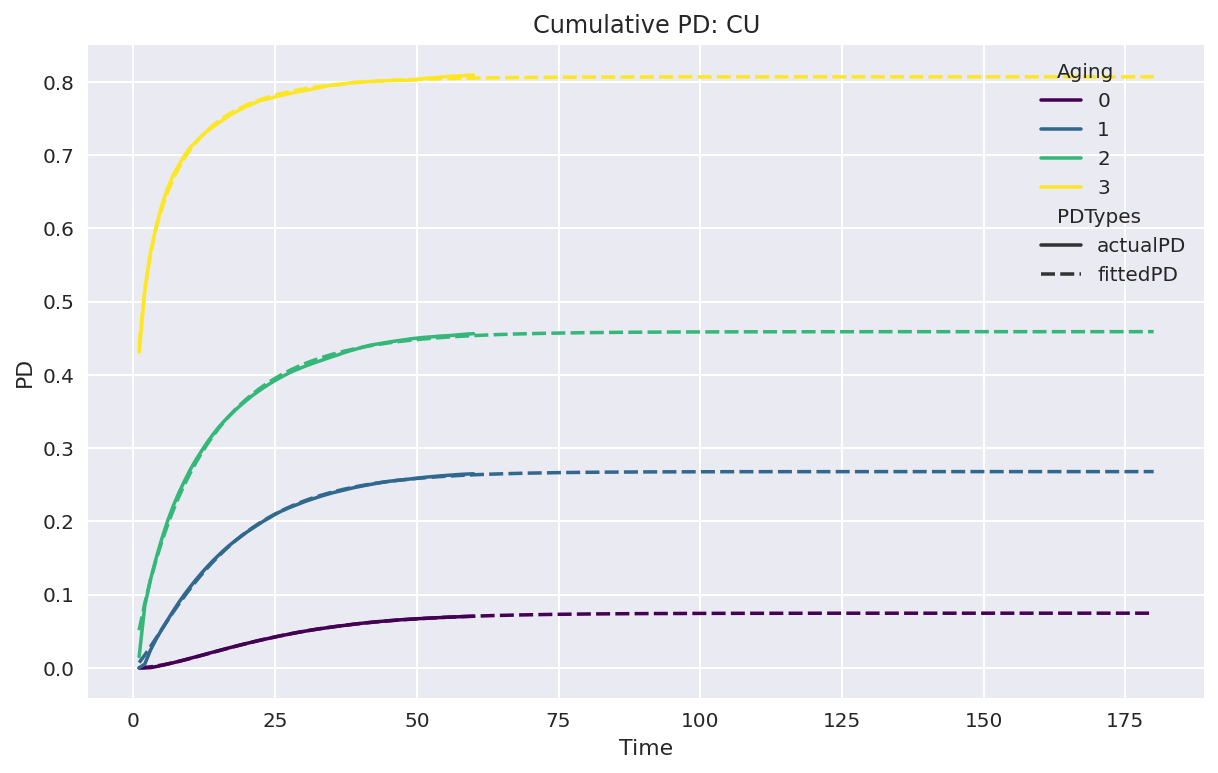

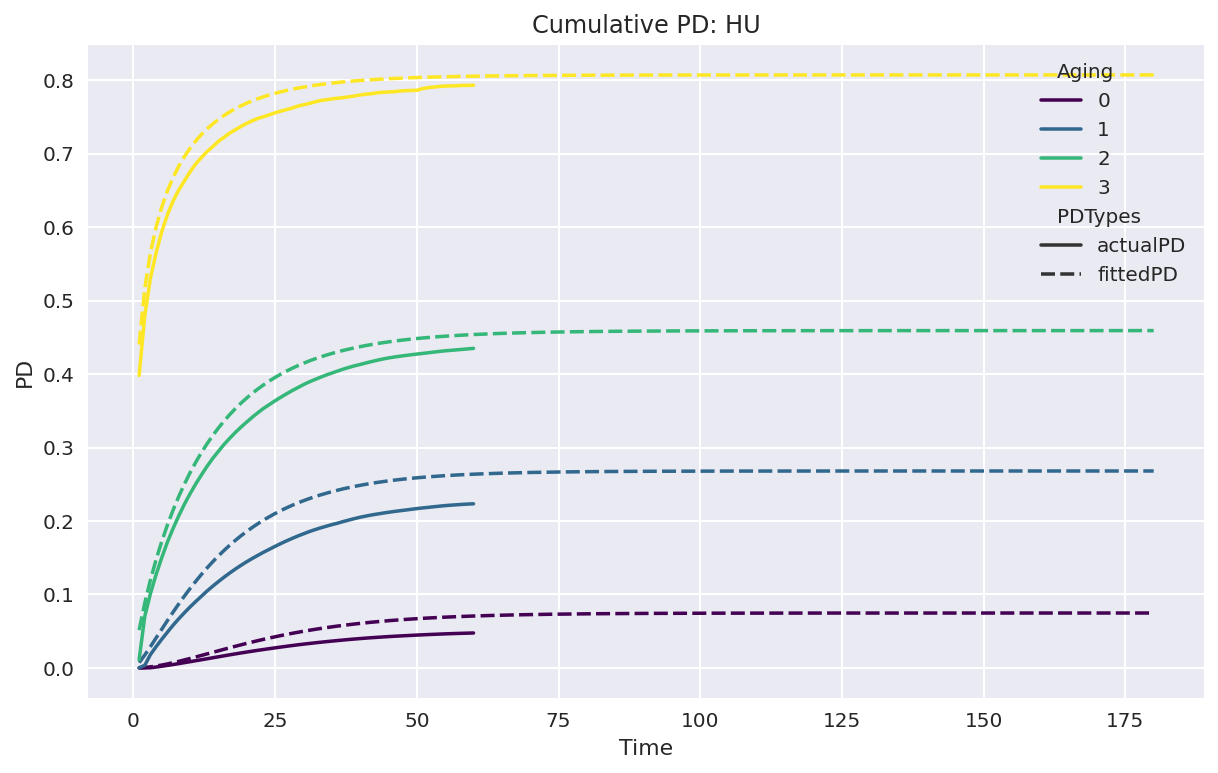

In [8]:
# Plot cumulative
plotCompare(comparedTable, 'cumPD')

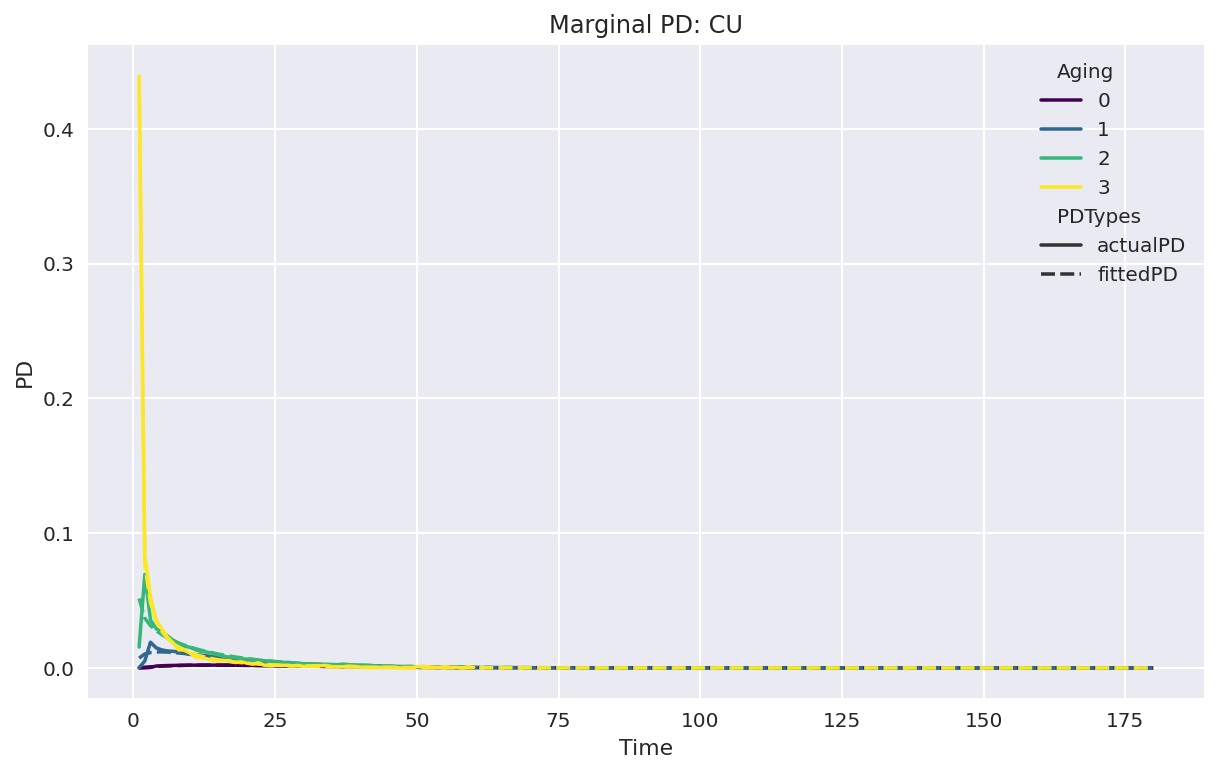

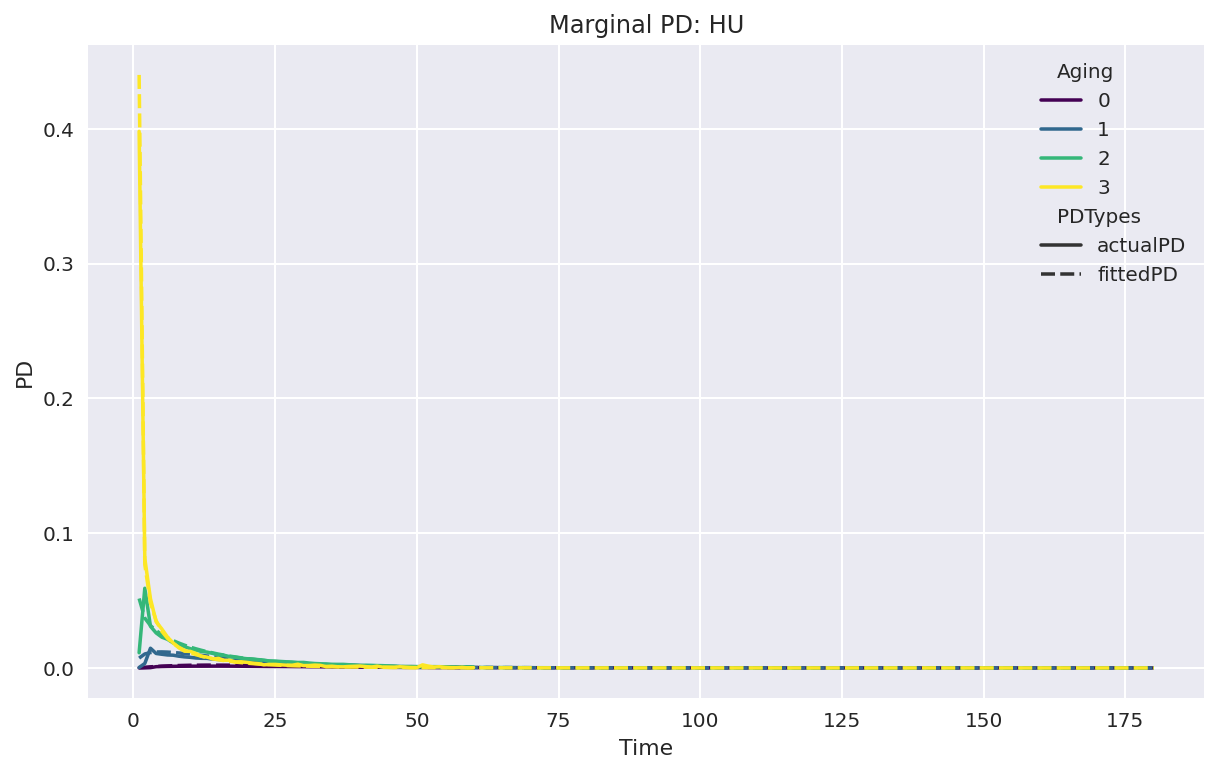

In [9]:
# Plot marginal
plotCompare(comparedTable, 'marPD')